In [1]:
import os
import gym
import torch
import math as mt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import namedtuple, deque
import time
import random
from InvertedPendulum import PendulumEnv

In [2]:
'''seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)'''

'seed = 0\nrandom.seed(seed)\ntorch.manual_seed(seed)\nnp.random.seed(seed)'

In [3]:
# Transition = namedtuple('Transition', ['s', 'a', 'r', 's_', 'd'])

# ReplayBuffer from https://github.com/seungeunrho/minimalRL
class ReplayBuffer():
    def __init__(self, 
                 buffer_size, 
                 device):
        self.buffer = deque(maxlen=buffer_size)
        self.device = device

    def save_tuple(self, tuple):
        self.buffer.append(tuple)

    def batch_sampling(self, 
               batch_size):
        batch = random.sample(self.buffer, 
                              batch_size)
        (current_state,
         action,
         reward,
         next_state,
         done) = ([], [], [], [], [])
        
        for tuple in batch:
            (temp_current_state,
             temp_action,
             temp_reward,
             temp_next_state,
             temp_done) = tuple
            current_state.append(temp_current_state)
            action.append(temp_action)
            reward.append([temp_reward])
            next_state.append(temp_next_state)
            done.append([1-int(temp_done)])

        current_state = torch.tensor(current_state,
                                     dtype=torch.float).to(self.device)
        action = torch.tensor(action,
                              dtype=torch.float).to(self.device)
        reward = torch.tensor(reward,
                              dtype=torch.float).to(self.device)
        next_state = torch.tensor(next_state,
                                  dtype=torch.float).to(self.device)
        done = torch.tensor(done,
                            dtype=torch.float).to(self.device)
        
        return current_state, action, reward, next_state, done

    def size(self):
        return len(self.buffer)

In [4]:
class ActorNetwork(nn.Module):
    def __init__(self, 
                 state_space, 
                 action_space,
                 learning_rate):
        super(ActorNetwork, self).__init__()

        self.FC_layer_1 = nn.Linear(state_space, 64)
        self.FC_layer_2 = nn.Linear(64, 64)
        self.FC_mean = nn.Linear(64, action_space)
        self.FC_log_standard_deviation = nn.Linear(64, action_space)

        self.log_standard_deviation_min = -20
        self.log_standard_deviation_max = 2

        self.action_value_max = 1
        self.action_value_min = -1

        self.action_scale = (self.action_value_max - self.action_value_min)/2.0
        self.action_bias = (self.action_value_max + self.action_value_min)/2.0

        self.optimizer = optim.Adam(self.parameters(),
                                    lr = learning_rate)
        
    def forward(self,
                state):
        
        x = F.leaky_relu(self.FC_layer_1(state))
        x = F.leaky_relu(self.FC_layer_2(x))

        mean = self.FC_mean(x)
        log_standard_deviation = self.FC_log_standard_deviation(x)

        log_standard_deviation = torch.clamp(log_standard_deviation,
                                             self.log_standard_deviation_min,
                                             self.log_standard_deviation_max)
        
        (action,
         log_probability) = self.sample_action(mean,
                                               log_standard_deviation)
        '''print("Mean Value", mean.detach())
        print("STD", torch.exp(log_standard_deviation).detach())'''

        return action, log_probability
    
    def sample_action(self,
                      mean,
                      log_standard_deviation):
        
        standard_deviation = torch.exp(log_standard_deviation)
        probability_distribution = Normal(mean,
                                          standard_deviation)
        
        sample = probability_distribution.rsample()
        x = torch.tanh(sample)

        action = self.action_scale * x + self.action_bias

        log_probability = probability_distribution.log_prob(sample)
        log_probability = log_probability - torch.sum(torch.log(self.action_scale * (1-x.pow(2)) + 1e-6),
                                                      dim = -1,
                                                      keepdim = True)
        
        return action, log_probability



In [5]:
class CriticNetwork(nn.Module):
    def __init__(self, 
                 state_space,
                 action_space,
                 learning_rate) -> None:
        super(CriticNetwork, self).__init__()

        self.FC_state = nn.Linear(state_space, 32)
        self.FC_action = nn.Linear(action_space, 32)

        self.FC_layer_1 = nn.Linear(64, 64)
        self.FC_layer_2 = nn.Linear(64, action_space)

        self.optimizer = optim.Adam(self.parameters(),
                                    lr = learning_rate)
        
    def forward(self,
                state,
                action):
        
        x = F.leaky_relu(self.FC_state(state))
        y = F.leaky_relu(self.FC_action(action))

        state_action = torch.cat([x, y], dim = -1)

        x = F.leaky_relu(self.FC_layer_1(state_action))
        stat_action_value = self.FC_layer_2(x)

        return stat_action_value

In [6]:
class SAC_Agent:
    def __init__(self,
                 state_space = 3,
                 action_space = 1,
                 actor_learning_rate = 0.001,
                 critic_learning_rate = 0.001,
                 batch_size = 200,
                 buffer_size = 100000,
                 discount_factor = 0.98,
                 tau = 0.005):
        
        self.state_space = state_space
        self.action_space = action_space
        self.actor_learning_rate = actor_learning_rate
        self.critic_learning_rate = critic_learning_rate
        self.discount_Factor = discount_factor
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.tau = tau

        self.initial_alpha = 0.01
        self.target_entropy = -self.action_space  # == -1
        self.alpha_learning_rate = 0.005

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.memory = ReplayBuffer(self.buffer_size, self.device)

        self.log_alpha = torch.tensor(np.log(self.initial_alpha)).to(self.device)
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = optim.Adam([self.log_alpha], 
                                              lr=self.alpha_learning_rate)

        self.Actor = ActorNetwork(state_space = self.state_space,
                                  action_space = self.action_space,
                                  learning_rate = self.actor_learning_rate).to(self.device)
        self.Critic_1 = CriticNetwork(state_space = self.state_space,
                                      action_space = self.action_space,
                                      learning_rate = self.critic_learning_rate).to(self.device)
        self.Critic_1_target = CriticNetwork(state_space = self.state_space,
                                             action_space = self.action_space,
                                             learning_rate = self.critic_learning_rate).to(self.device)
        self.Critic_2 = CriticNetwork(state_space = self.state_space,
                                      action_space = self.action_space,
                                      learning_rate = self.critic_learning_rate).to(self.device)
        self.Critic_2_target = CriticNetwork(state_space = self.state_space,
                                             action_space = self.action_space,
                                             learning_rate = self.critic_learning_rate).to(self.device)

        self.Critic_1_target.load_state_dict(self.Critic_1.state_dict())
        self.Critic_2_target.load_state_dict(self.Critic_2.state_dict())

    def action_selection(self, state):
        with torch.no_grad():
            action, log_probability = self.Actor(state.to(self.device))
        return action, log_probability

    def compute_discouted_reward(self, batch):
        (current_state,
         action,
         reward,
         next_state,
         done) = batch
        
        with torch.no_grad():
            (next_state_action,
             next_state_log_probabilities) = self.Actor(next_state)
            entropy = - self.log_alpha.exp() * next_state_log_probabilities
            state_action_value_1 = self.Critic_1_target(next_state,
                                                        next_state_action)
            state_action_value_2 = self.Critic_2_target(next_state,
                                                        next_state_action)
            
            state_action_value = torch.min(state_action_value_1, state_action_value_2)
            discounted_reward = reward + self.discount_Factor * done * (state_action_value + entropy)

        return discounted_reward

    def training(self):

        batch = self.memory.batch_sampling(batch_size = self.batch_size)
        (current_state,
         action,
         reward,
         next_state,
         done) = batch

        discounted_reward = self.compute_discouted_reward(batch)

        critic_loss_1 = F.smooth_l1_loss(self.Critic_1(current_state,
                                                       action),
                                         discounted_reward)
        self.Critic_1.optimizer.zero_grad()
        critic_loss_1.mean().backward()
        self.Critic_1.optimizer.step()

        critic_loss_2 = F.smooth_l1_loss(self.Critic_2(current_state,
                                                       action),
                                         discounted_reward)
        self.Critic_2.optimizer.zero_grad()
        critic_loss_2.mean().backward()
        self.Critic_2.optimizer.step()

        predicted_action, log_probability = self.Actor(current_state)
        entropy = -self.log_alpha.exp() * log_probability

        state_action_value_1 = self.Critic_1(current_state, 
                                             predicted_action) 
        state_action_value_2 = self.Critic_2(current_state, 
                                             predicted_action)
        state_action_value = torch.min(state_action_value_1, state_action_value_2)
        actor_loss = -(state_action_value + entropy)  
        self.Actor.optimizer.zero_grad()
        actor_loss.mean().backward()
        self.Actor.optimizer.step()

        self.log_alpha_optimizer.zero_grad()
        alpha_loss = -(self.log_alpha.exp() * (log_probability + self.target_entropy).detach()).mean()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        for param_target, param in zip(self.Critic_1_target.parameters(), self.Critic_1.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)
        for param_target, param in zip(self.Critic_2_target.parameters(), self.Critic_2.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

        return actor_loss.mean().detach()

In [7]:
def state_preprocessing(raw_input):
    state = []
    state.append(raw_input[0])
    state.append(mt.cos(raw_input[2]))
    state.append(mt.sin(raw_input[2]))
    state.append(raw_input[3])

    return state

In [8]:
'''enviroment = gym.make('Pendulum-v1')'''
enviroment = PendulumEnv()
state_space = enviroment.observation_space.shape[0]
action_space = enviroment.action_space.shape[0]

In [9]:
max_time_steps = 2000
number_of_episodes = 500
batch_size = 200
buffer_size = 100000
discount_factor = 0.98
actor_learning_rate = 0.001
critic_learning_rate = 0.001
tau = 0.005

Agent = SAC_Agent(state_space = state_space,
                  action_space = action_space,
                  batch_size = batch_size,
                  buffer_size = buffer_size,
                  discount_factor = discount_factor,
                  actor_learning_rate = actor_learning_rate,
                  critic_learning_rate = critic_learning_rate,
                  tau = tau)

In [10]:
score = []
actor_loss = []
print("Start Training:...")

for current_episode in range(number_of_episodes):
    episodic_score = 0
    (current_state, _) = enviroment.reset()
    current_state = state_preprocessing(current_state)

    for current_time_step in range(max_time_steps):

        (action,
         log_probability) = Agent.action_selection(torch.FloatTensor(current_state))
        action = action.detach().cpu().numpy()

        (next_state,
         reward,
         done,
         info,
         _) = enviroment.step(action[0])
        next_state = state_preprocessing(next_state)

        Agent.memory.save_tuple((current_state,
                                 action,
                                 reward,
                                 next_state,
                                 done))
        
        print("Time Step:", current_time_step+1)
        print("Current State:", current_state)
        print("Action Value:", action)
        print("Next State:", next_state)
        print("Reward:", reward)
        
        episodic_score += reward
        current_state = next_state

        if done == True:
            break

        if Agent.memory.size() > 500:
            #print("...")
            episodic_actor_loss = Agent.training()
            actor_loss.append(episodic_actor_loss)

    if Agent.memory.size() > 500:
        print("Episode:{}, Score:{:.1f}, Actor Loss:{:.3f}".format(current_episode+1, 
                                                                   episodic_score, 
                                                                   episodic_actor_loss))
    score.append(episodic_score) 
    time.sleep(10)

print("Finish Training:...")

Start Training:...
Time Step: 1
Current State: [0.0, -0.9999999999999962, -8.742278000372475e-08, 0.0]
Action Value: [-0.8426201]
Next State: [0.0, -0.9999999999999962, -8.742278000372475e-08, -3.510917]
Reward: -11.1200084185743
Time Step: 2
Current State: [0.0, -0.9999999999999962, -8.742278000372475e-08, -3.510917]
Action Value: [-0.9095032]
Next State: [-0.046812225, -0.9846313564277577, 0.17464561815068286, -7.3005137]
Reward: -14.147863628968919
Time Step: 3
Current State: [-0.046812225, -0.9846313564277577, 0.17464561815068286, -7.3005137]
Action Value: [-0.7016796]
Next State: [-0.1441524, -0.8574146600055043, 0.5146261757894225, -9.575482]
Reward: -15.946606105203172
Time Step: 4
Current State: [-0.1441524, -0.8574146600055043, 0.5146261757894225, -9.575482]
Action Value: [0.67521554]
Next State: [-0.27664456, -0.5239233965254556, 0.851765387048118, -5.5807548]
Reward: -7.629812539455213
Time Step: 5
Current State: [-0.27664456, -0.5239233965254556, 0.851765387048118, -5.58075

/var/folders/5d/v7pmycsx3ld6mf_2fksw9vzc0000gn/T/ipykernel_4716/401122758.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  action = torch.tensor(action,


Time Step: 71
Current State: [-2.6692715, 0.7336358181186162, 0.6795428510207643, 13.187693]
Action Value: [0.22790726]
Next State: [-2.4834156, 0.1635353847066569, 0.9865374691053785, 12.774456]
Reward: -18.298278877736255
Time Step: 72
Current State: [-2.4834156, 0.1635353847066569, 0.9865374691053785, 12.774456]
Action Value: [0.24045262]
Next State: [-2.2673562, -0.4568493979429735, 0.8895440560192298, 14.144402]
Reward: -24.190888313078123
Time Step: 73
Current State: [-2.2673562, -0.4568493979429735, 0.8895440560192298, 14.144402]
Action Value: [0.17513536]
Next State: [-2.015193, -0.9252409524910006, 0.37937999398168865, 17.20496]
Reward: -37.17790163045492
Time Step: 74
Current State: [-2.015193, -0.9252409524910006, 0.37937999398168865, 17.20496]
Action Value: [0.174148]
Next State: [-1.7214109, -0.8910598111565552, -0.4538859029994699, 20.384996]
Reward: -48.686977813596314
Time Step: 75
Current State: [-1.7214109, -0.8910598111565552, -0.4538859029994699, 20.384996]
Action V

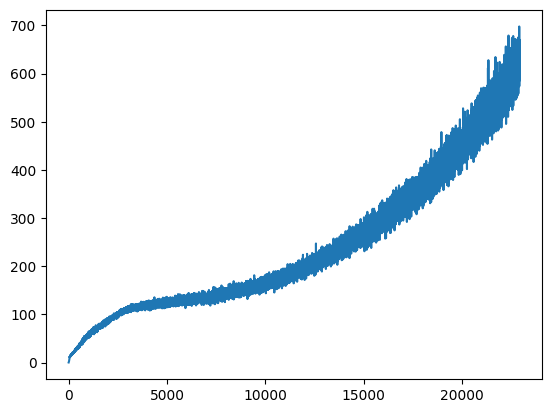

In [11]:
plt.plot(actor_loss)
plt.show()

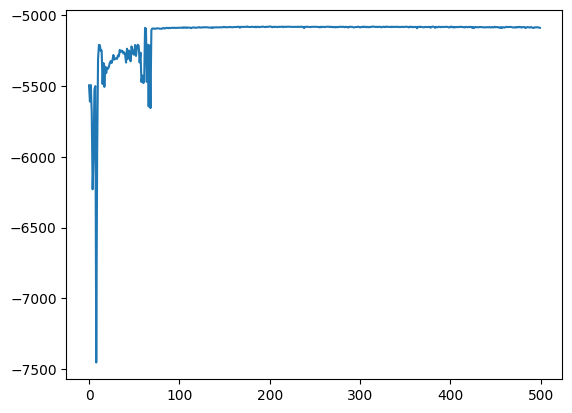

In [12]:
plt.plot(score)
plt.show()